In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam

In [5]:
mpl.rcParams['figure.figsize'] = (20, 6)  # Width, Height in inches
plt.figure(figsize=(25, 6))

<Figure size 2500x600 with 0 Axes>

<Figure size 2500x600 with 0 Axes>

In [150]:
def preprocess_data_v2():
    file_name = "port_ray.xlsx"
    df = pd.read_excel(file_name)

    return df

In [147]:
# preprocess data
def preprocess_data():
    file_name = "PGMs_Prices_RVAE_v2_Feb24.xlsx"
    df = pd.read_excel(file_name)

    df['Date'] = pd.to_datetime(df['Date'])
    # Convert timestamps to Unix timestamps (seconds since epoch)
    df['UnixTs'] = df['Date'].astype('int64') // 10**9  # Convert nanoseconds to seconds


    # create portofolio value & return 
    df['Portfolio_Value'] = df['AU_PX_LAST'] * 500 + df['AG_PX_LAST'] * 100000 + df['PT_PX_LAST'] * 5000 + df['PD_PX_LAST'] * 2000
    df['Portfolio_Return'] = np.log(df['Portfolio_Value'] / df['Portfolio_Value'].shift(-1))
    

    # position


    # add volatility attributes
    window_size = 5

    # window volatility -> window
    day_volatility = pd.Series(df['Portfolio_Return']).rolling(window=window_size).std().dropna() * 100
    df = df.drop(df.index[:window_size])

    # scale by 10o times
    # Define thresholds for low, medium, and high volatility regimes
    low_threshold = np.percentile(day_volatility, 33)
    high_threshold = np.percentile(day_volatility, 66)

    # Classify volatility into regimes based on thresholds
    regime_labels = np.where(day_volatility < low_threshold, 'L',
                            np.where(day_volatility < high_threshold, 'M', 'H'))

    # Create a DataFrame with volatility data and regime labels
    df[['Volatility', 'Regime']] = pd.DataFrame({'Volatility': day_volatility, 'Regime': regime_labels})

    return df

In [153]:
df = preprocess_data_v2()
df.columns.values[1] = 'Return'

df.head(10)

,Date,Return
0,2017-08-07,0.0
1,2017-08-08,-32070.0
2,2017-08-09,14990.0
3,2017-08-10,-7280.0
4,2017-08-11,38710.0
5,2017-08-14,-102220.0
6,2017-08-15,36030.0
7,2017-08-16,-52910.0
8,2017-08-17,-39340.0
9,2017-08-18,12560.0


In [66]:
# output scaled plot
def scaled_plot():
    # Corresponding Y-axis values for two lines (different lengths)
    y_gold = df['AU_PX_LAST']
    y_silver = df['AG_PX_LAST']
    y_platinum = df['PT_PX_LAST']
    y_palldium = df['PD_PX_LAST']

    total_value = df['Portfolio_Value']

    # scale Y axis
    y_gold_scaled = [val / max(y_gold) for val in y_gold]
    y_silver_scaled = [val / max(y_silver) for val in y_silver]
    y_pl_scaled = [val / max(y_platinum) for val in y_platinum]
    y_pa_scaled = [val / max(y_palldium) for val in y_palldium]

    value_scaled = [val /max(total_value) for val in total_value]

    plt.plot(df['Date'], value_scaled, label='Value', linestyle='-', color='orange')
    plt.plot(df['Date'], df['Portfolio_Return'], label='Return', linestyle='-', color='green')

    plt.plot(df['Date'], y_gold_scaled, label='Gold', linestyle='-',  alpha=0.2, color='black')
    plt.plot(df['Date'], y_silver_scaled, label='Silver', linestyle='-', color='brown')
    plt.plot(df['Date'], y_pl_scaled, label='Platinum', linestyle='-', color='purple')
    plt.plot(df['Date'], y_pa_scaled, label='Palldium', linestyle='-', color='blue')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Y-axis Label')
    plt.title('Line Chart with Multiple Lines (Different Lengths)')

    # Format the date ticks on the X-axis for better readability
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend()

    # Display the chart
    plt.tight_layout()
    plt.show()

    plt.savefig('initial_portofolio_scale.png')

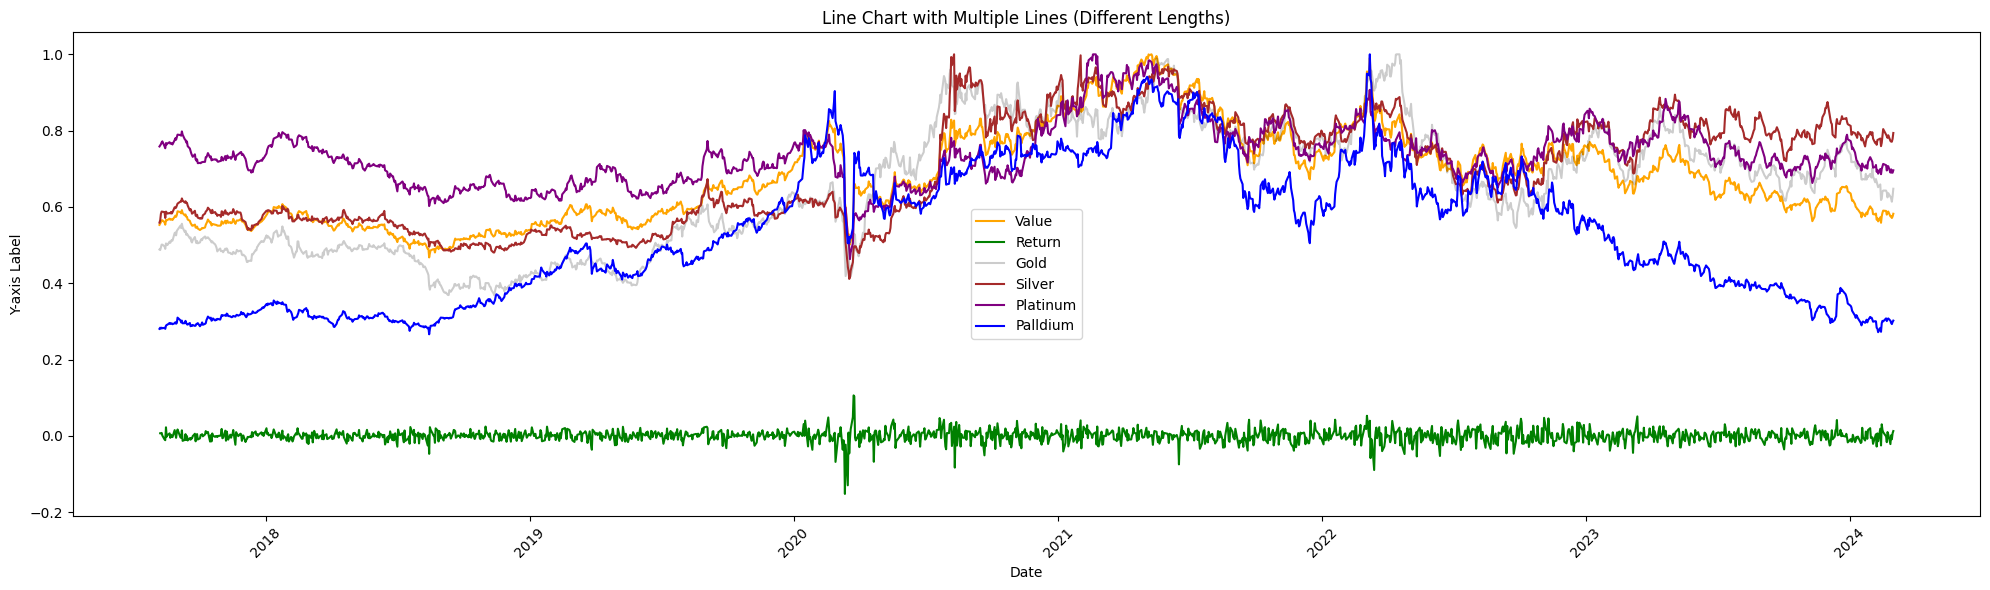

<Figure size 2000x600 with 0 Axes>

In [128]:
scaled_plot()

In [70]:
def plot_volatility():
    sum_by_category = df.groupby('Regime')['Regime'].count()
    print(sum_by_category)

    # Plot the volatility
    plt.plot(df['Date'], df['Volatility'], label='Volatility', linestyle='--', color='orange')

    # plt.plot(df['Date'].drop(df.index[:window_size]), day_volatility, label='Volatility', linestyle='--', color='orange')
    # Define colors for each regime label
    colors = {'L': 'blue', 'M': 'green', 'H': 'red'}

    # Plot volatility data with different colors for each regime label
    for regime, color in colors.items():
        regime_data = df[df['Regime'] == regime]
        plt.scatter(regime_data['Date'], regime_data['Volatility'], color=color, label=regime)

    plt.title('Volatility Plot')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    # plt.show()

    plt.savefig('volatility_with_regime.jpg')

Regime
H    561
L    546
M    545
Name: Regime, dtype: int64


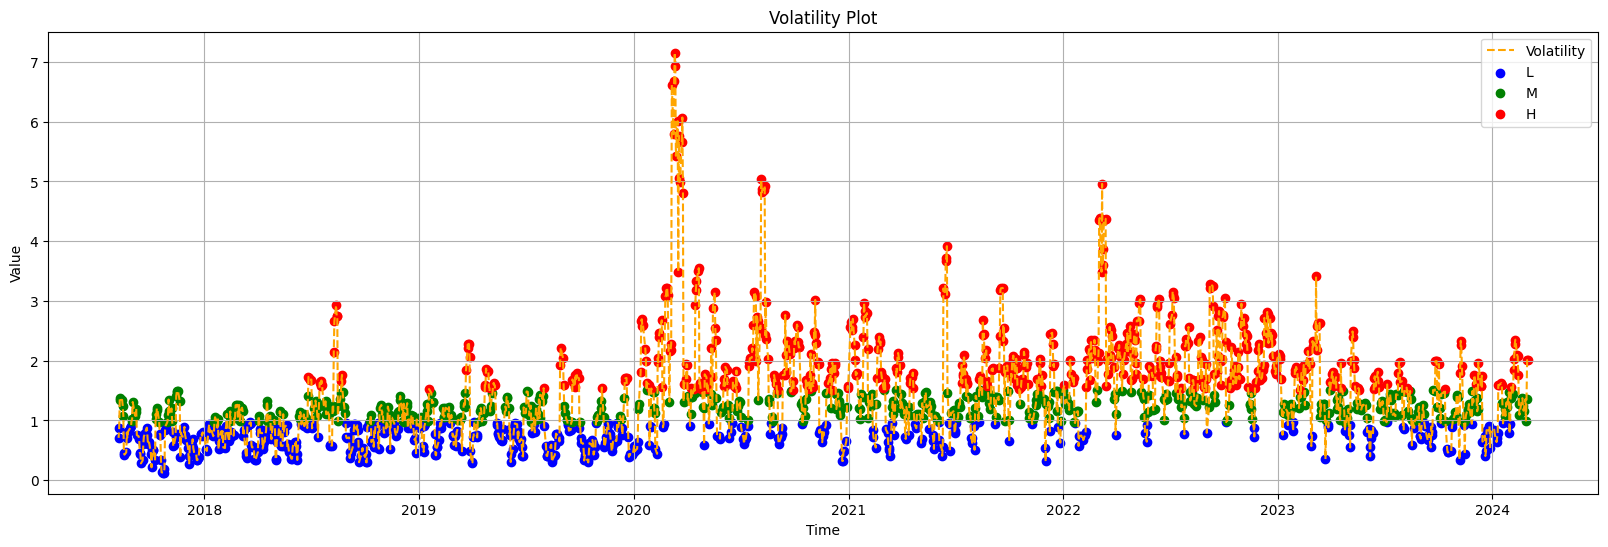

In [129]:
plot_volatility()

In [130]:
def plot_volatility_v2():
    day_volatility = df['Volatility']
    # Classify volatility into regimes based on thresholds
    low_volatility = day_volatility < low_threshold
    medium_volatility = (day_volatility >= low_threshold) & (day_volatility < high_threshold)
    high_volatility = day_volatility >= high_threshold

    # Plot the original volatility data
    # plt.plot(volatility, color='black', label='Volatility')

    # Shade areas for each volatility regime
    plt.fill_between(range(len(day_volatility)), day_volatility.squeeze(), where=low_volatility.squeeze(), color='blue', alpha=0.3, label='Low Volatility')
    plt.fill_between(range(len(day_volatility)), day_volatility.squeeze(), where=medium_volatility.squeeze(), color='green', alpha=0.3, label='Medium Volatility')
    plt.fill_between(range(len(day_volatility)), day_volatility.squeeze(), where=high_volatility.squeeze(), color='red', alpha=0.3, label='High Volatility')

    # Add labels and legend
    plt.xlabel('Data Point Index')
    plt.ylabel('Volatility')
    plt.legend()

    plt.savefig('volatility.jpg')


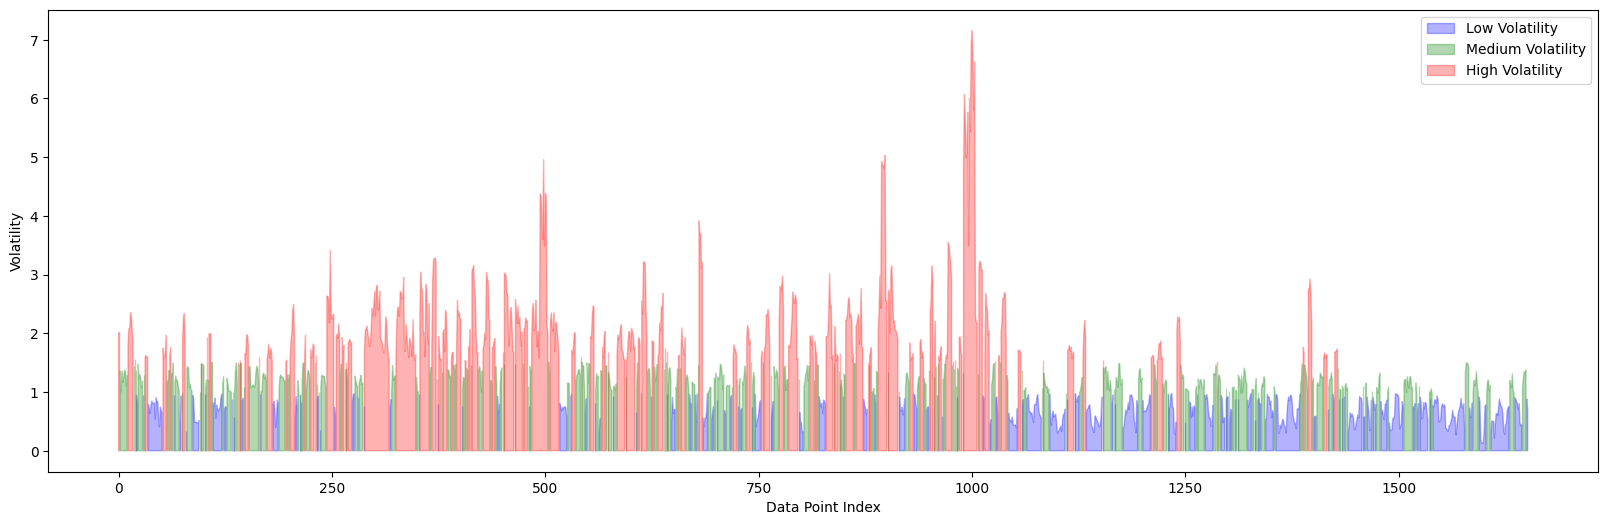

In [131]:
plot_volatility_v2()

In [74]:
# normalize data
# df.drop(columns=['Date'], inplace=True)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()


# Calculate original means and standard deviations before normalization
original_means = df[numeric_columns].mean()
original_std_devs = df[numeric_columns].std()


normalized_data = (df[numeric_columns] - original_means) / original_std_devs
# first 4 and last 1 is na for volatility
normalized_data.fillna(0)

# normalized_data = normalized_data.drop('Volatility', axis=1)

normalized_volatility = normalized_data[['UnixTs', 'Volatility']]

regular_volatility = df[['UnixTs', 'Volatility']]


In [87]:
# Windowing: Creating sequences/windows
sequence_length = 5  # which is the rolling window dates

def prep_seqdata_for_model(dfrme):
    sequences = []
    size = len(dfrme)

    if (size == sequence_length):
        return np.array(dfrme)

    for i in range(size - sequence_length):
        sequences.append(dfrme[i:i+sequence_length])
    sequences = np.array(sequences)

    return sequences


In [132]:
sequences = prep_seqdata_for_model(df['Volatility'])

In [133]:
# Split data into train and validation sets
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
val_data = sequences[train_size:]

In [134]:
# Define the autoencoder model
num_features = 1

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])

# custom_learning_rate = 0.00001  # Adjust this value as needed
# adam_optimizer = Adam(learning_rate=custom_learning_rate)

In [135]:
model.compile(optimizer='adam', loss='mse')

# Training the autoencoder
model.fit(train_data, train_data, epochs=200, batch_size=32, validation_data=(val_data, val_data))


Epoch 1/200
42/42 [==============================] - 5s 22ms/step - loss: 2.4814 - val_loss: 0.4401
Epoch 2/200
42/42 [==============================] - 0s 8ms/step - loss: 1.3705 - val_loss: 0.3329
Epoch 3/200
42/42 [==============================] - 0s 8ms/step - loss: 0.9616 - val_loss: 0.3710
Epoch 4/200
42/42 [==============================] - 0s 8ms/step - loss: 0.6737 - val_loss: 0.2333
Epoch 5/200
42/42 [==============================] - 0s 8ms/step - loss: 0.4834 - val_loss: 0.1307
Epoch 6/200
42/42 [==============================] - 0s 8ms/step - loss: 0.2941 - val_loss: 0.0906
Epoch 7/200
42/42 [==============================] - 0s 9ms/step - loss: 0.1984 - val_loss: 0.0647
Epoch 8/200
42/42 [==============================] - 0s 8ms/step - loss: 0.1535 - val_loss: 0.0611
Epoch 9/200
42/42 [==============================] - 0s 8ms/step - loss: 0.1222 - val_loss: 0.0455
Epoch 10/200
42/42 [==============================] - 0s 8ms/step - loss: 0.1061 - val_loss: 0.0438
Epoch 11

In [137]:
# save model
from tensorflow.keras.models import save_model, load_model

# Assuming autoencoder_model is your trained model
model.save('cpd_model_.h5')


In [138]:
# load model for test
cpd_model = load_model('cpd_model_.h5')

In [82]:
def classify_volatility(volatility, low_threshold, medium_threshold):
    return 'High' if volatility >= medium_threshold else \
           'Medium' if volatility >= low_threshold else 'Low'

In [84]:
def predict_volatility():
    # predict today's regime
    last_record = val_data[-1]
    reshaped_data = np.expand_dims(last_record, axis=0).reshape((1,) + last_record.shape)
    x = cpd_model.predict(reshaped_data)

    pred_volatility = x[0][4][0]

    return pred_volatility

In [85]:
pred_volatility = predict_volatility()

In [86]:
result = classify_volatility(pred_volatility, low_threshold, high_threshold)
print(f"The volatility level is: {result}")

The volatility level is: Low


In [146]:
# Reconstruction of validation data
predicted_data = cpd_model.predict(sequences)

# Calculating reconstruction loss
# remove extra dimension from predicted_va_data
predicted_data = predicted_data.squeeze(axis=-1)
reconstruction_losses = np.mean(np.square(sequences - predicted_data), axis=(1, ))

# MSE
mse = np.mean((sequences - predicted_data) ** 2)
rmse = np.sqrt(mse)

print(f"mse: {mse} \nrmse: {rmse}")


# Define a threshold for detecting regime changes
# Calculate mean and standard deviation of reconstruction errors on validation set
error_mean = np.mean(reconstruction_losses)
error_std = np.std(reconstruction_losses)

# Set threshold as a multiple of standard deviation above the mean error
threshold = error_mean + error_std/2

print(f"error_mean {error_mean}\nerror_std {error_std}\nthreshold {threshold}")

# Detect regime changes based on the threshold for validation dataset
regime_change_indices = np.where(reconstruction_losses > threshold)[0]
regime_change_indices



all_regime_change_indices = regime_change_indices

print(f'\nTotal Change Points: {len(all_regime_change_indices)}')

mse: 0.01589648449320338 
rmse: 0.12608126146737025
error_mean 0.01589648449320338
error_std 0.03191893991677556
threshold 0.03185595445159116

Total Change Points: 194


In [144]:
# Reshape the 3D array to 2D, dropping the middle dimension
reshaped_data = predicted_data.reshape(-1, predicted_data.shape[-1])

# Convert the 2D NumPy array to a DataFrame
df_pred = pd.DataFrame(reshaped_data)
df_pred['Date'] = pd.to_datetime(regular_volatility['UnixTs'], unit='s')  # 's' for seconds, 'ms' for milliseconds


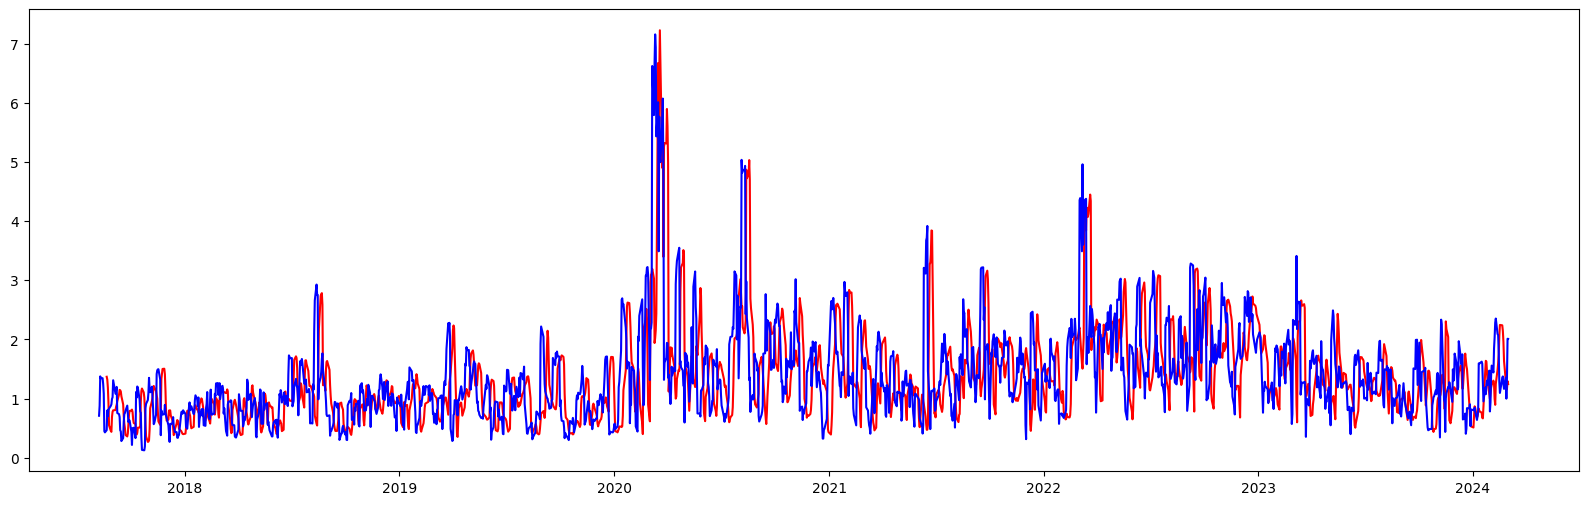

In [145]:
# Plot the data and change points
# plt.plot(df_pred['Date'], df_pred[0], label='Volatility', color="gray")
plt.plot(df_pred['Date'], df_pred[1], label='Volatility', color="red")

regular_volatility['Date'] = pd.to_datetime(regular_volatility['UnixTs'], unit='s')  # 's' for seconds, 'ms' for milliseconds

plt.plot(regular_volatility['Date'], regular_volatility['Volatility'], color='blue')

In [140]:
# group change points
from sklearn.cluster import DBSCAN
# Reshape the data for DBSCAN (needed for sklearn)
X = all_regime_change_indices.reshape(-1, 1)

# DBSCAN parameters
epsilon = sequence_length * 8 # Maximum distance between points to be considered in the same neighborhood
min_samples = sequence_length * 3  # Minimum number of samples in a neighborhood

In [141]:
# DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Getting cluster labels and core sample indices
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

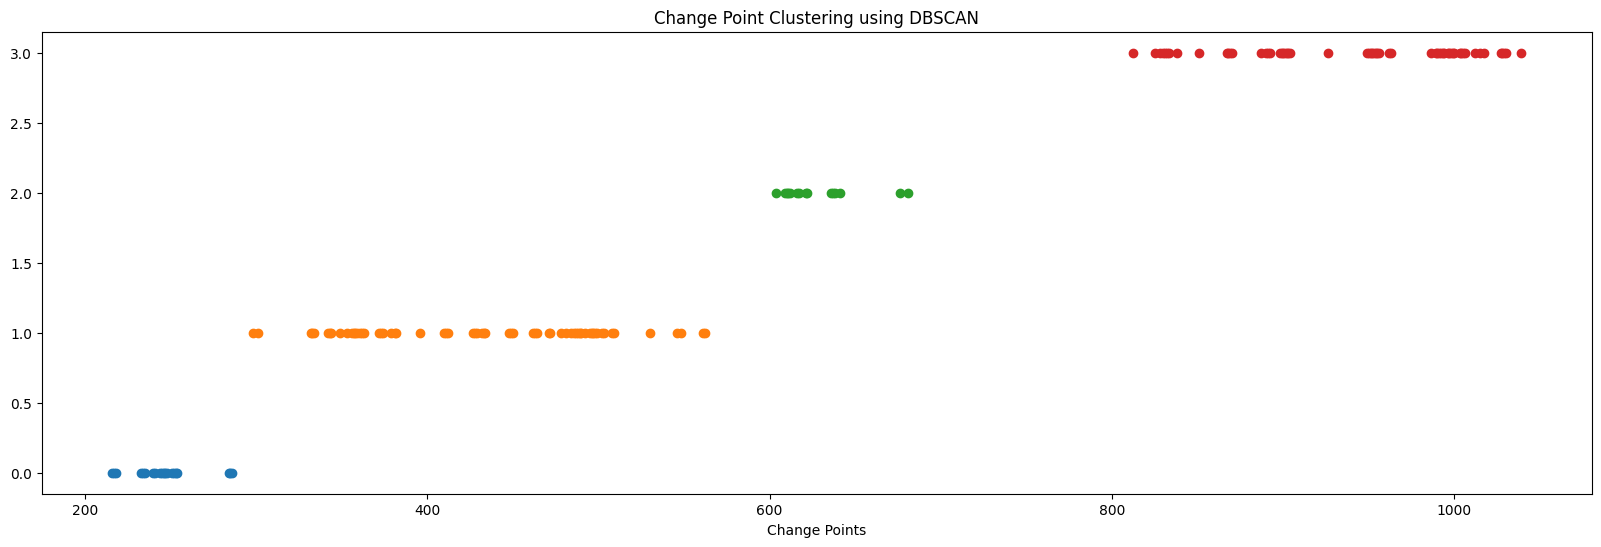

Cluster 0: Change Points - [array([216, 217, 218, 233, 234, 235, 240, 241, 244, 245, 246, 247, 248,
       251, 252, 253, 254, 284, 285, 286], dtype=int64)]
Cluster 1: Change Points - [array([298, 301, 332, 333, 334, 342, 343, 344, 349, 353, 356, 357, 358,
       359, 361, 362, 363, 372, 373, 374, 379, 381, 382, 396, 410, 411,
       412, 427, 428, 429, 432, 433, 434, 448, 449, 450, 462, 463, 464,
       471, 472, 478, 481, 484, 486, 487, 488, 489, 490, 492, 495, 496,
       497, 498, 499, 502, 503, 508, 509, 530, 546, 548, 561, 562],
      dtype=int64)]
Cluster 2: Change Points - [array([604, 609, 610, 611, 612, 616, 617, 621, 622, 636, 637, 638, 641,
       676, 681], dtype=int64)]
Cluster 3: Change Points - [array([ 812,  825,  828,  830,  831,  832,  833,  838,  851,  867,  868,
        869,  870,  887,  890,  891,  892,  898,  899,  900,  901,  902,
        903,  904,  926,  949,  950,  951,  952,  953,  954,  955,  956,
        962,  963,  986,  989,  990,  991,  992,  993,  994,

In [142]:
from collections import defaultdict

# Extracting unique clusters and their indices
unique_labels = set(cluster_labels)
cluster_change_points = defaultdict(list)

if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label (-1)


for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    cluster_change_points[label].append(cluster_points)
    plt.plot(cluster_points, np.ones_like(cluster_points) * label, 'o', label=f'Cluster {label}')

plt.xlabel('Change Points')
plt.title('Change Point Clustering using DBSCAN')
# plt.legend()
plt.show()

# Print or process cluster-wise change points
for cluster, points in cluster_change_points.items():
    print(f"Cluster {cluster}: Change Points - {points}")

# Problematic

In [92]:
# if a regime has more than 50% high volatility, then classify as high volatile regime
# similarly for medium and low volatility

# Dictionary to store regime classifications
regime_classifications = {}

# Calculate percentage of high volatility change points for each regime
for cluster, points in cluster_change_points.items():
    # Calculate the percentage of high volatility change points
    total_change_points = len(points[0])
    high_volatility_count = sum(df[change_point] == 'H' for change_point in points[0])
    high_volatility_percentage = high_volatility_count / total_change_points

    high_volatility_count = sum(df[change_point] == 'H' for change_point in points)
    high_volatility_percentage = high_volatility_count / total_change_points
    
    # Classify the regime based on the percentage
    # Classify the regime based on the percentage
    classification = 'High' if high_volatility_percentage >= 0.5 else \
                 'Medium' if high_volatility_percentage >= 0.5 else 'Low'

    
    # Store the classification for the regime
    regime_classifications[regime] = classification

# Print regime classifications
for regime, classification in regime_classifications.items():
    print(f"Regime {regime}: {classification} volatility")



KeyError: 20

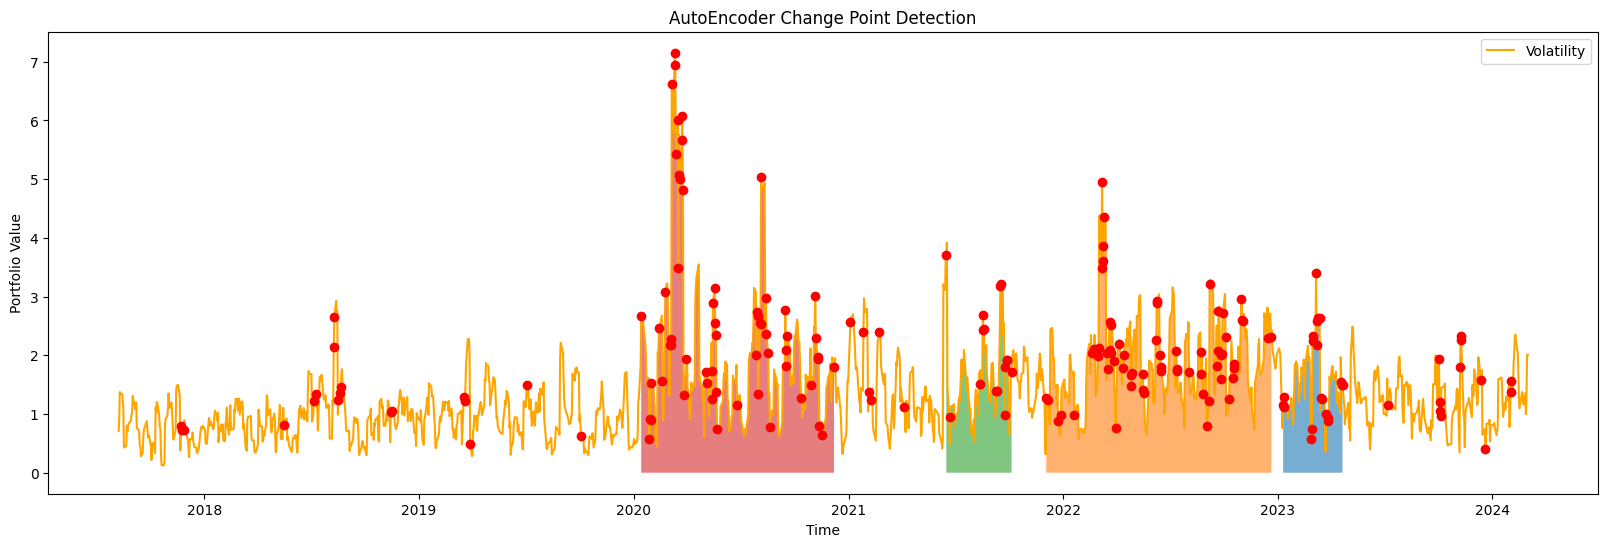

In [143]:
# Plot the data and change points
# plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
plt.plot(df['Date'], df['Volatility'], label='Volatility', color="orange")


# Mark the change points on the chart
for change_point in all_regime_change_indices:
    plt.scatter(df['Date'].iloc[change_point], df['Volatility'].iloc[change_point], marker='o', color='red', zorder=3)

for cluster, points in cluster_change_points.items():
    # cluster_label = f"Cluster {cluster}"
    index_range = points[0]

    start_index = index_range[0]
    end_index = index_range[len(index_range) -1]

    plt.fill_between(df['Date'][start_index:end_index+1], df['Volatility'][start_index:end_index+1], alpha=0.6)

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title('AutoEncoder Change Point Detection')
plt.legend()

# the above figure shall be saved and then served
plt.savefig('regime.png')

In [46]:
regimes = []

# Assuming 'data' is your DataFrame and 'all_regime_change_indices' contains change points
for i in range(len(all_regime_change_indices)):
    start_index = all_regime_change_indices[i]
    if i == len(all_regime_change_indices) - 1:
        end_index = len(df) - 1  # Use the last index of the data as the end index for the last regime
    else:
        end_index = all_regime_change_indices[i + 1]

    regime_window = df.iloc[start_index:end_index]
    regimes.append({
        'Regime': f'Regime_{i + 1}',
        'Start_Index': start_index,
        'End_Index': end_index,
        'Data': regime_window
    })

#regimes

In [49]:
# Gather recent 5 day's record
last_5_records = sequencing(regular_volatility.tail(5))

# reshape
# last_5_records_reshaped = np.expand_dims(last_5_records, axis=0)  # Add a batch dimension
# last_5_records_reshaped = np.expand_dims(last_5_records_reshaped, axis=1)  # Add a time step dimension


reconstructed_data = cpd_model.predict(last_5_records)
reconstruction_error = np.mean(np.square(last_5_records - reconstructed_data), axis=1)

if reconstruction_error > threshold:
    print("Regime change predicted for today!")
else:
    print("No regime change predicted for today.")
    # output current regime (low - medium - high volativlity)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).